In [3]:
!pip install disarray

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import disarray

In [5]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [6]:
train_path = '/kaggle/input/multiclassbtsegmentedimages/segmented_bt/train_directory'
validation_path = '/kaggle/input/multiclassbtsegmentedimages/segmented_bt/validation_directory'
test_path = '/kaggle/input/multiclassbtsegmentedimages/segmented_bt/test_directory'

In [7]:
preprocess_input = tensorflow.keras.applications.densenet.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [9]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [11]:
tl_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 13,461,063 (51.35 MB)

 Trainable params: 13,377,415 (51.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [12]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.1,
    patience=2,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [14]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [15]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight = class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - categorical_accuracy: 0.4235 - f1_score: 0.3443 - loss: 10.4978 - precision: 0.6913 - recall: 0.2399 - top_2_accuracy: 0.6110 - top_3_accuracy: 0.7468
Epoch 1: val_categorical_accuracy improved from -inf to 0.84145, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 461s 538ms/step - categorical_accuracy: 0.4236 - f1_score: 0.3445 - loss: 10.4948 - precision: 0.6914 - recall: 0.2401 - top_2_accuracy: 0.6111 - top_3_accuracy: 0.7469 - val_categorical_accuracy: 0.8414 - val_f1_score: 0.8129 - val_loss: 0.4810 - val_precision: 0.8522 - val_recall: 0.7907 - val_top_2_accuracy: 0.9083 - val_top_3_accuracy: 0.9683 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - categorical_accuracy: 0.6279 - f1_score: 0.5964 - loss: 6.5633 - precision: 0.7887 - recall: 0.4816 - top_2_accuracy: 0.8037 - top_3_accuracy: 0.9004
Epoch 2: val_categorical_accuracy improved from 0.84145 to 0.86410, saving model to best_model

In [16]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

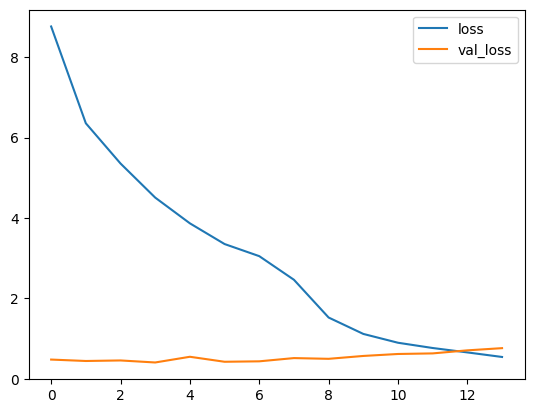

In [17]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

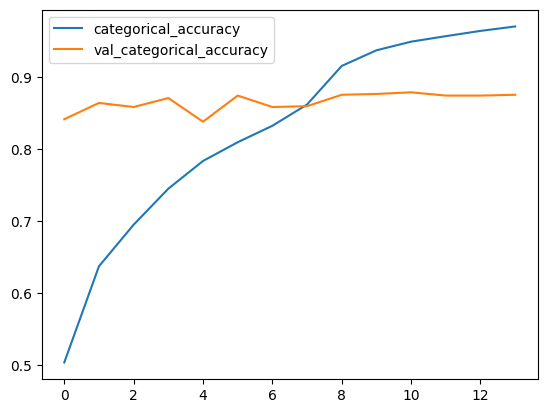

In [18]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

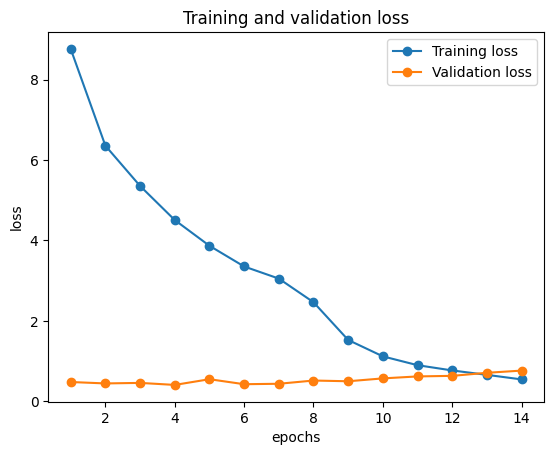

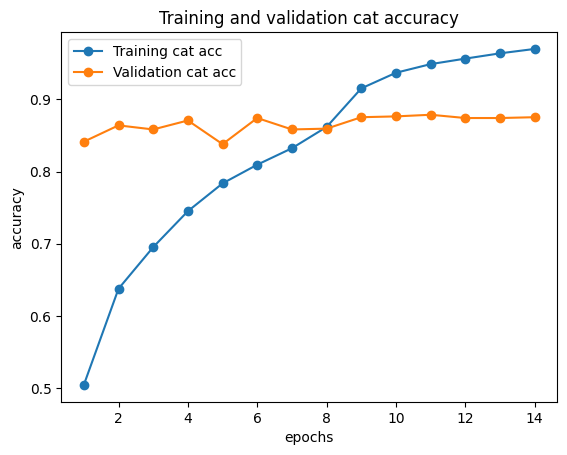

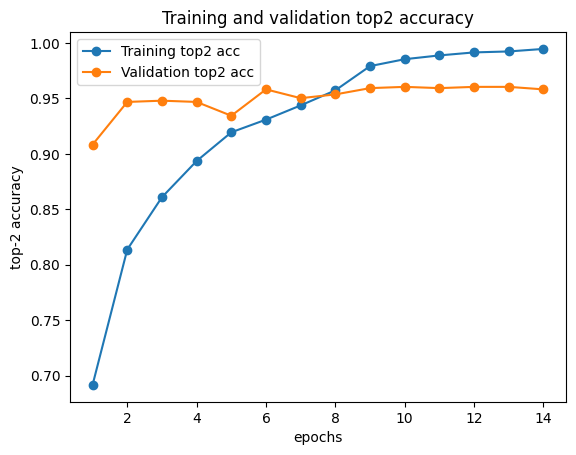

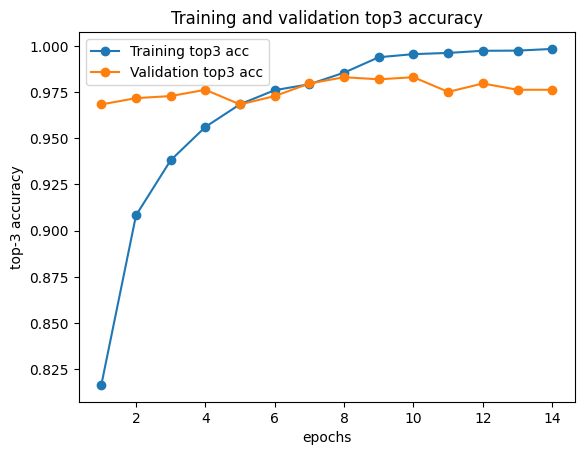

<Figure size 640x480 with 0 Axes>

In [19]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [20]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [21]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - categorical_accuracy: 0.7781 - f1_score: 0.7809 - loss: 1.2516 - precision: 0.7863 - recall: 0.7756 - top_2_accuracy: 0.9121 - top_3_accuracy: 0.9407
val_loss: 0.6198245286941528
val_cat_acc: 0.8788222074508667
val_top_2_acc: 0.9592298865318298
val_top_3_acc: 0.9750849604606628
val_precision: 0.8844523429870605
val_recall: 0.8766412734985352
val_f1_score 0.8804933428764343


In [22]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [23]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 822ms/step - categorical_accuracy: 0.7743 - f1_score: 0.7726 - loss: 1.1671 - precision: 0.7785 - recall: 0.7670 - top_2_accuracy: 0.8968 - top_3_accuracy: 0.9515
test_loss: 0.5766708850860596
test_cat_acc: 0.8839528560638428
test_top_2_acc: 0.9483227729797363
test_top_3_acc: 0.9800543785095215
test_precision: 0.8856403827667236
test_recall: 0.8788773417472839
test_f1_score 0.8821976780891418


In [24]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 578ms/step


Normalized confusion matrix
[[0.43333333 0.03333333 0.36666667 0.         0.06666667 0.1
  0.        ]
 [0.11428571 0.57142857 0.2        0.         0.05714286 0.05714286
  0.        ]
 [0.         0.02272727 0.625      0.         0.13636364 0.21590909
  0.        ]
 [0.         0.25       0.25       0.125      0.125      0.25
  0.        ]
 [0.         0.         0.2173913  0.         0.47826087 0.30434783
  0.        ]
 [0.         0.00226501 0.01698754 0.00226501 0.01359003 0.96489241
  0.        ]
 [0.         0.         0.         0.         0.         0.07692308
  0.92307692]]


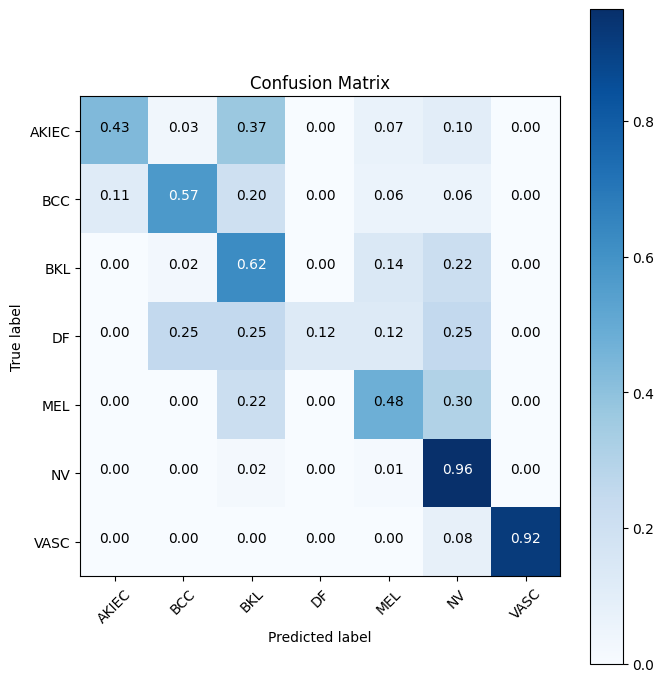

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [26]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.980961,0.980054,0.929284,0.991840,0.951949,0.934723,0.999093,0.966844
f1,0.553191,0.645161,0.585106,0.181818,0.453608,0.959459,0.960000,0.883953
false_discovery_rate,0.235294,0.259259,0.450000,0.666667,0.568627,0.045913,0.000000,0.116047
false_negative_rate,0.566667,0.428571,0.375000,0.875000,0.521739,0.035108,0.076923,0.116047
false_positive_rate,0.003728,0.006554,0.044335,0.001826,0.027436,0.186364,0.000000,0.019341
negative_predictive_value,0.984346,0.986059,0.967099,0.993636,0.977186,0.852381,0.999083,0.980659
positive_predictive_value,0.764706,0.740741,0.550000,0.333333,0.431373,0.954087,1.000000,0.883953
precision,0.764706,0.740741,0.550000,0.333333,0.431373,0.954087,1.000000,0.883953
recall,0.433333,0.571429,0.625000,0.125000,0.478261,0.964892,0.923077,0.883953
sensitivity,0.433333,0.571429,0.625000,0.125000,0.478261,0.964892,0.923077,0.883953


In [27]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [28]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - categorical_accuracy: 0.7271 - f1_score: 0.6776 - loss: 0.8270 - precision: 0.7304 - recall: 0.6429 - top_2_accuracy: 0.8882 - top_3_accuracy: 0.9511
val_loss: 0.4086441695690155
val_cat_acc: 0.8708946704864502
val_top_2_acc: 0.9467723965644836
val_top_3_acc: 0.9762174487113953
val_precision: 0.8779892325401306
val_recall: 0.8286720514297485
val_f1_score 0.8499006032943726


In [29]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [30]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - categorical_accuracy: 0.7291 - f1_score: 0.6609 - loss: 0.8778 - precision: 0.7142 - recall: 0.6278 - top_2_accuracy: 0.8635 - top_3_accuracy: 0.9448
test_loss: 0.4236530065536499
test_cat_acc: 0.8676337003707886
test_top_2_acc: 0.9356300830841064
test_top_3_acc: 0.974614679813385
test_precision: 0.8747460842132568
test_recall: 0.8252893686294556
test_f1_score 0.8461717367172241


In [31]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step


Normalized confusion matrix
[[0.43333333 0.1        0.16666667 0.         0.13333333 0.16666667
  0.        ]
 [0.22857143 0.62857143 0.         0.         0.02857143 0.11428571
  0.        ]
 [0.05681818 0.04545455 0.36363636 0.01136364 0.06818182 0.45454545
  0.        ]
 [0.         0.125      0.         0.125      0.         0.75
  0.        ]
 [0.         0.02173913 0.04347826 0.         0.34782609 0.58695652
  0.        ]
 [0.         0.01019253 0.00679502 0.00453001 0.00453001 0.97395243
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


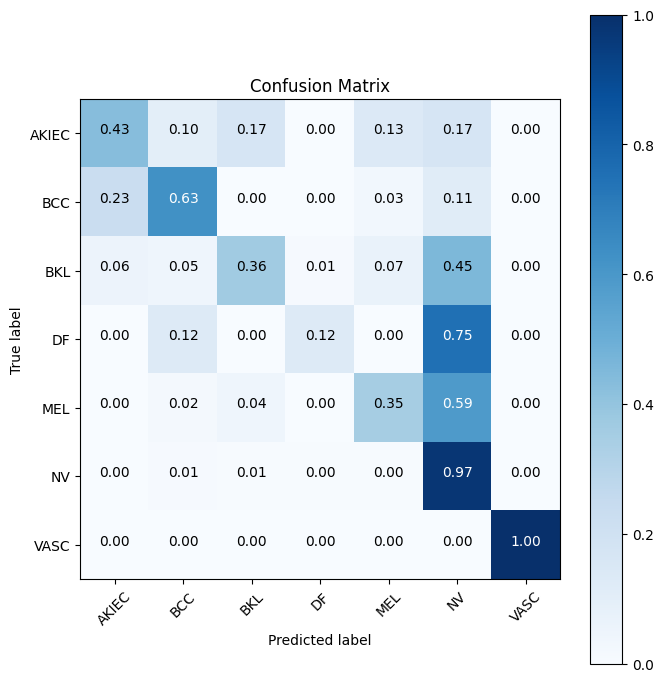

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [33]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.972801,0.971895,0.937443,0.989121,0.959202,0.904805,1.0,0.962181
f1,0.464286,0.586667,0.481203,0.142857,0.415584,0.942466,1.0,0.867634
false_discovery_rate,0.500000,0.450000,0.288889,0.833333,0.483871,0.087049,0.0,0.132366
false_negative_rate,0.566667,0.371429,0.636364,0.875000,0.652174,0.026048,0.0,0.132366
false_positive_rate,0.012116,0.016854,0.012808,0.004566,0.014191,0.372727,0.0,0.022061
negative_predictive_value,0.984215,0.987770,0.947070,0.993619,0.972015,0.857143,1.0,0.977939
positive_predictive_value,0.500000,0.550000,0.711111,0.166667,0.516129,0.912951,1.0,0.867634
precision,0.500000,0.550000,0.711111,0.166667,0.516129,0.912951,1.0,0.867634
recall,0.433333,0.628571,0.363636,0.125000,0.347826,0.973952,1.0,0.867634
sensitivity,0.433333,0.628571,0.363636,0.125000,0.347826,0.973952,1.0,0.867634
